In [1]:
# import other files
import sys

sys.path.append("..")

In [108]:
# common functions
from common import missing_data_check, plot_histograms
# fetch functions
from etl.fetch import *
# environment variables
from dotenv import load_dotenv
import os
# data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
# working with data
import numpy as np
from collections import Counter
from itertools import chain
# import seaborn as sns

In [61]:
# load environment variables
load_dotenv()

like_playlist_id = os.getenv("LIKE_PLAYLIST_ID")
dislike_playlist_id = os.getenv("DISLIKE_PLAYLIST_ID")

token = get_token()

'''
Personal playlist columns:
- artist_id, track_id, track_name, popularity, user_like
'''
like_playlist = get_playlist_tracks(token, like_playlist_id)
like_playlist['user_like'] = True
dislike_playlist = get_playlist_tracks(token, dislike_playlist_id)
dislike_playlist['user_like'] = False
songs = pd.concat([like_playlist, dislike_playlist])

'''
Track feature columns:
- 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
    'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
    'time_signature'
'''
track_ids = ','.join(songs.track_id.to_list())
track_features = get_track_features(token, track_ids).drop(columns=['analysis_url', 'track_href', 'type', 'uri'])

'''
Artist feature columns:
- 'artist_id', 'genres', 'name', 'popularity'
'''
artist_ids = ','.join(songs.artist_id.to_list())
artist_features = get_artist_attribute(token, artist_ids).drop(columns=['name', 'popularity'])

2023-11-19 20:24:45 INFO Fetching tracks...
2023-11-19 20:24:46 INFO Fetching tracks...
2023-11-19 20:24:47 INFO Fetching track features...
2023-11-19 20:24:49 INFO Fetching artist(s)...


In [ ]:
missing_data_check(track_features)

Checked to see if for any reason any of the tracks have missing audio features. This does not seem to be the case.

In [138]:
def missing_genres_check(dataframe):
    dataframe['is_missing_genre'] = dataframe.genres.astype(bool)    
    total = dataframe.is_missing_genre[dataframe.is_missing_genre == False].count()
    pct = (total / dataframe.is_missing_genre.count()) * 100
    result = pd.DataFrame({'Total':total, 'Percent':pct}, index=['is_missing_genre'])
    return result

missing_genres_check(artist_features)

,Total,Percent
is_missing_genre,61,13.26087


We have that ~13% of the artists in my personal playlist are missing genres. This might be because these artists are not as well known and so Spotify has yet to assign them a genre.

An interesting observation is that genres are associated with an artist rather than a song. If I were to associate a song's genre(s) by its artist(s), this would mean that the song would belong to all of the genres of all of the participating artists. This assumption may cause problems when a particular artist has multiple genres that are vastly different but I will proceed this way for simplicity's sake.

In [ ]:
# Build final dataframe
df = songs.merge(track_features, how='inner', left_on='track_id', right_on='id').drop(columns=['id'])
# Split up artist ids
df[['artist_id1', 'artist_id2', 'artist_id3', 'artist_id4', 'artist_id5']] = df['artist_id'].str.split(',', expand=True)
# Join in genres on artist ids
df = df.drop(columns=['artist_id'])
df = df.merge(artist_features, how='left', left_on='artist_id1', right_on='artist_id').drop(columns=['artist_id', 'artist_id1']).rename(columns={'genres':'genres1'})
df = df.merge(artist_features, how='left', left_on='artist_id2', right_on='artist_id').drop(columns=['artist_id', 'artist_id2']).rename(columns={'genres':'genres2'})
df = df.merge(artist_features, how='left', left_on='artist_id3', right_on='artist_id').drop(columns=['artist_id', 'artist_id3']).rename(columns={'genres':'genres3'})
df = df.merge(artist_features, how='left', left_on='artist_id4', right_on='artist_id').drop(columns=['artist_id', 'artist_id4']).rename(columns={'genres':'genres4'})
df = df.merge(artist_features, how='left', left_on='artist_id5', right_on='artist_id').drop(columns=['artist_id', 'artist_id5']).rename(columns={'genres':'genres5'})
df = df.replace(np.nan, "")

In [99]:
# Merge lists across columns
def combine_lists(row):
    combined_list = []
    for col in row:        
        if len(col) > 0:   
            combined_list.extend(col)
    return list(set(combined_list))

# Combine genres columns
df['genres'] = df[['genres1', 'genres2', 'genres3', 'genres4', 'genres5']].apply(combine_lists, axis=1)
df = df.drop(columns=['genres1', 'genres2', 'genres3', 'genres4', 'genres5'])


Now visualizing the audio features of songs that I like vs. songs that I do not like...

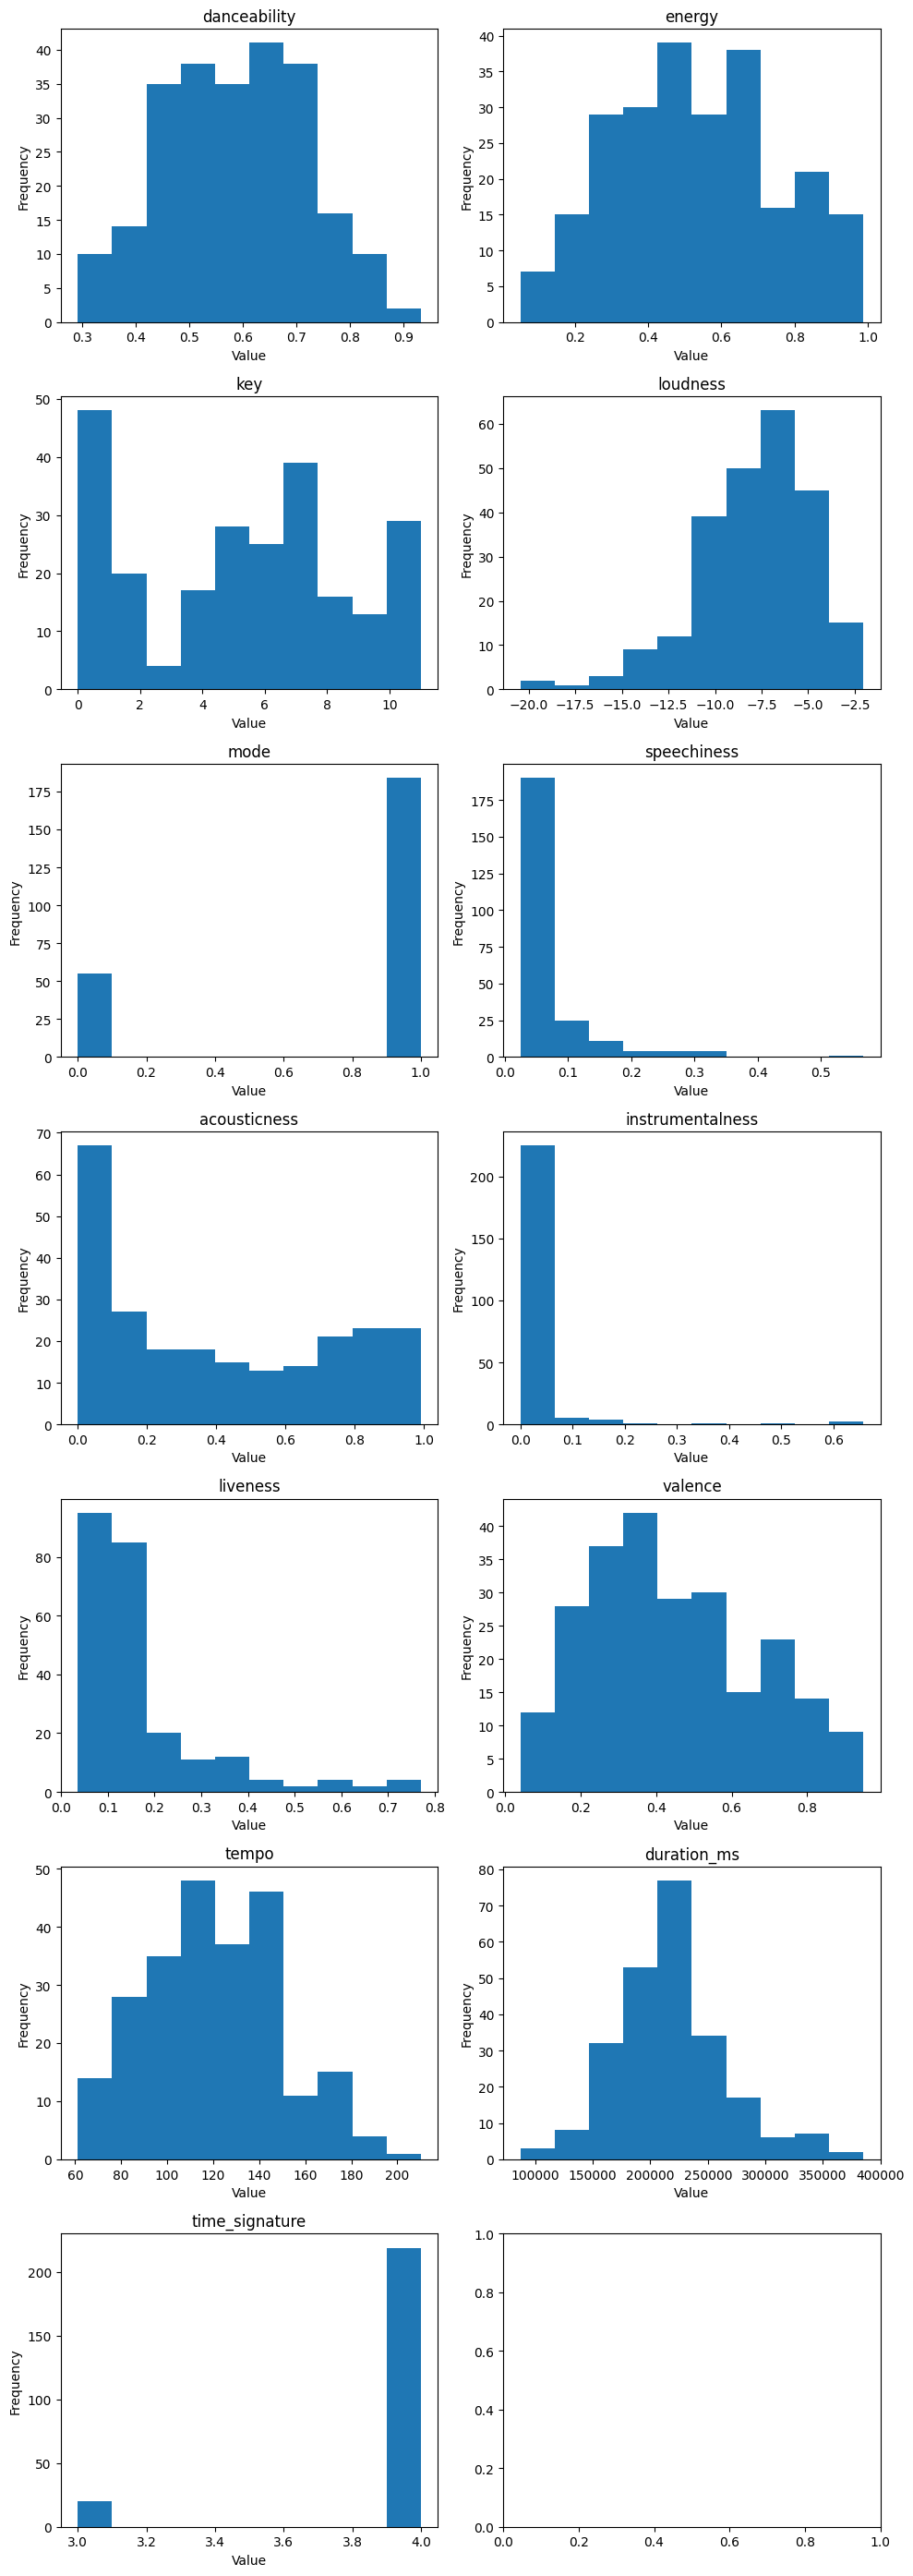

In [116]:
# TODO: data visualization on distribution of audio features
# TODO: data visualization on distribution of genres

features = df[df.user_like == True][['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']]

plot_histograms(features)

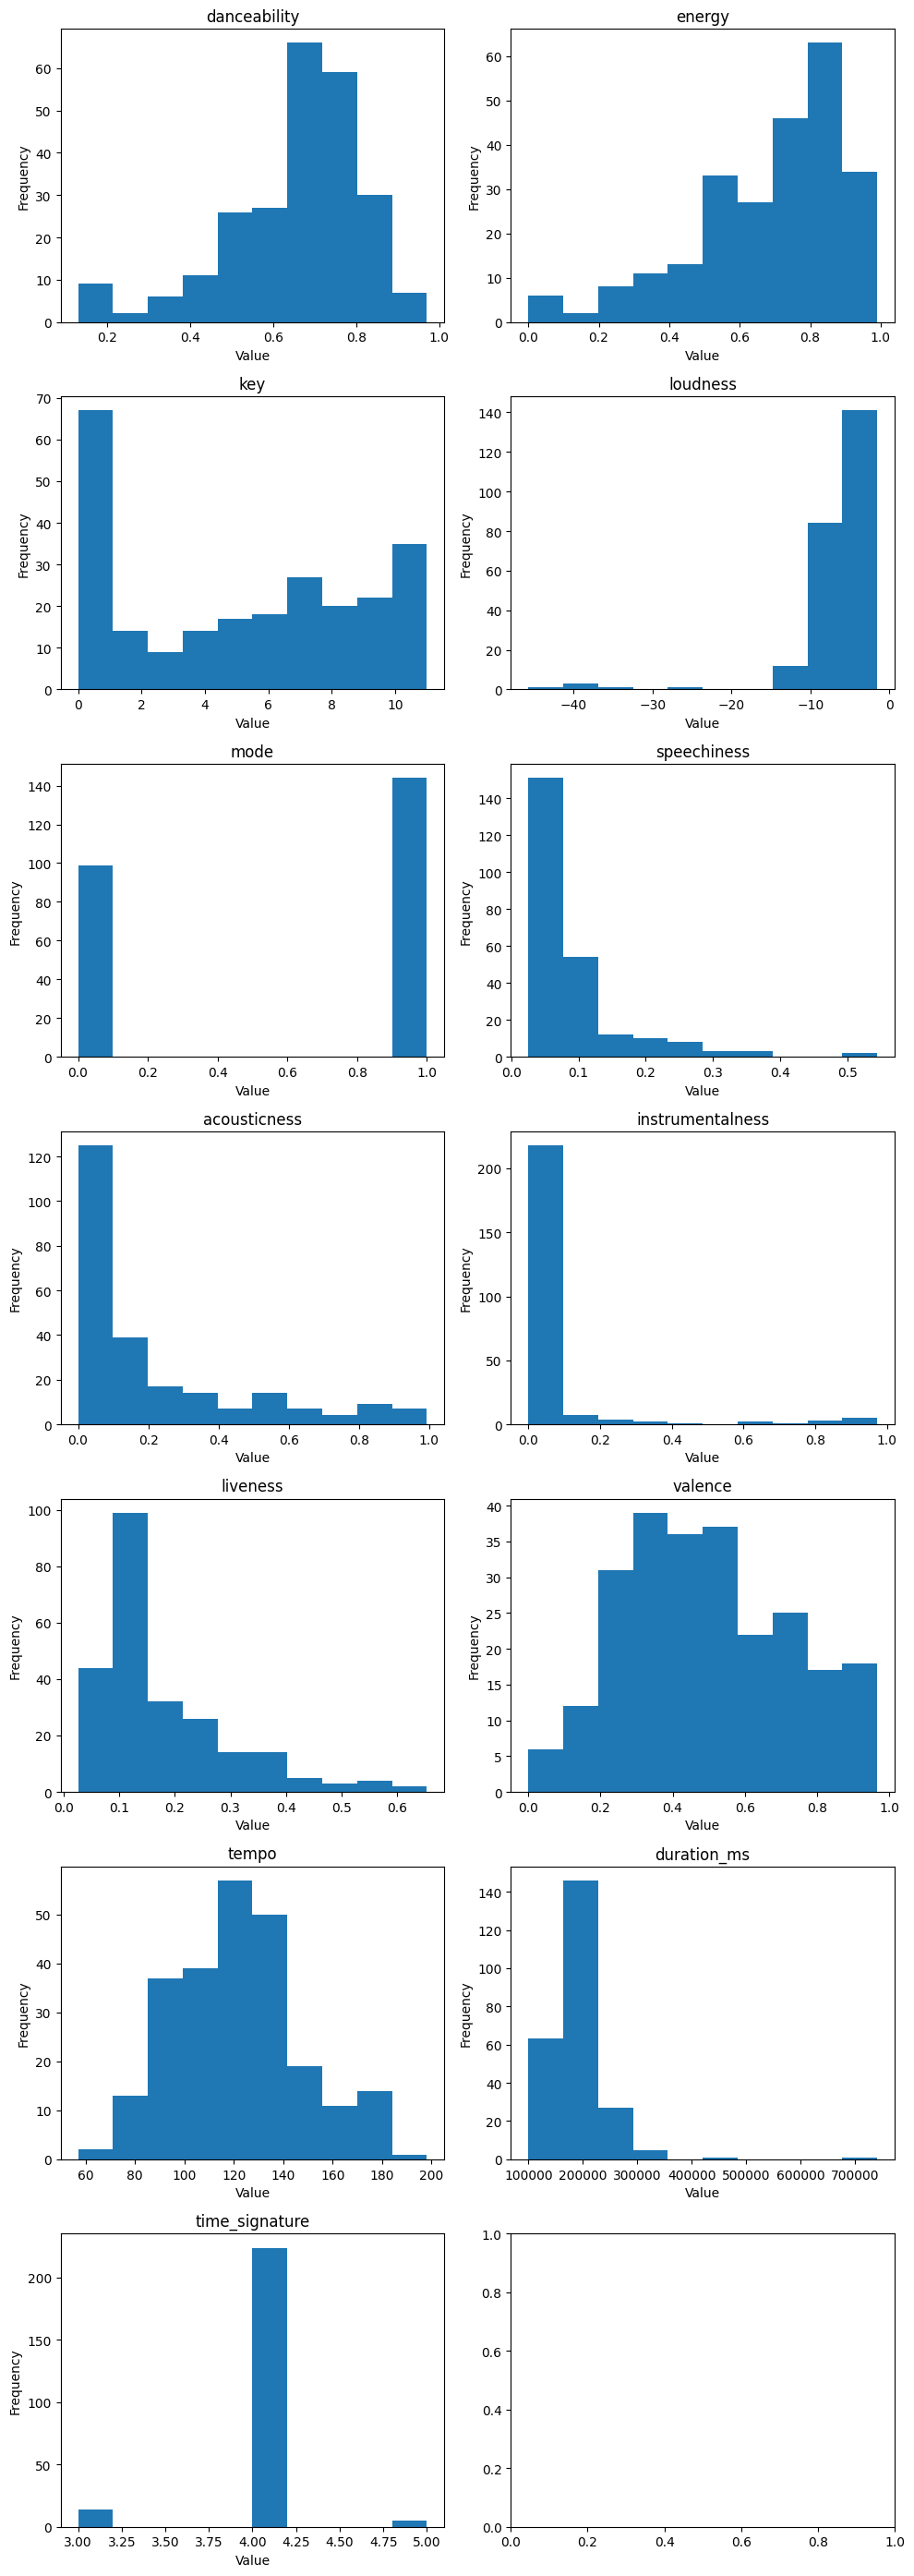

In [117]:
features = df[df.user_like == False][['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']]

plot_histograms(features)

There are 482 songs in total, 239 liked songs and 243 disliked songs.

Summary of exploratory analysis on audio features:
- Songs that I dislike are on average: 
    - higher in danceability and energy
    - similar in loudness but skewed left heavier (i.e. some songs are a lot louder)
- Other audio features, based on visual inspection, are either similar or have negligible differences


In [123]:
like_genres = df[df.user_like == True]['genres'].explode().value_counts().reset_index()
like_genres.columns = ['Genre', 'Frequency']
dislike_genres = df[df.user_like == False]['genres'].explode().value_counts().reset_index()
dislike_genres.columns = ['Genre', 'Frequency']


In [124]:
like_most_freq_genre = like_genres[like_genres.Frequency == max(like_genres.Frequency)]
like_least_freq_genre = like_genres[like_genres.Frequency == min(like_genres.Frequency)]
dislike_most_freq_genre = dislike_genres[dislike_genres.Frequency == max(dislike_genres.Frequency)]
dislike_least_freq_genre = dislike_genres[dislike_genres.Frequency == min(dislike_genres.Frequency)]

In [132]:
like_most_freq_genre, dislike_most_freq_genre

(  Genre  Frequency
 0   pop         66,
   Genre  Frequency
 0   pop         62)

In [131]:
like_least_freq_genre, dislike_least_freq_genre

(                          Genre  Frequency
 82                    candy pop          1
 83   christian alternative rock          1
 84                      pop emo          1
 85                new americana          1
 86                neon pop punk          1
 ..                          ...        ...
 171                  french pop          1
 172  nouvelle chanson francaise          1
 173           indie anthem-folk          1
 174       neo-singer-songwriter          1
 175            modern folk rock          1
 
 [94 rows x 2 columns],
                    Genre  Frequency
 110              europop          1
 111           french pop          1
 112            pop house          1
 113         new wave pop          1
 114              pop edm          1
 ..                   ...        ...
 257              norteno          1
 258  musica chihuahuense          1
 259        pop argentino          1
 260       reggaeton flow          1
 261         desi emo rap          1
 


In [142]:
missing_genres_check(df[df.user_like == True])
missing_genres_check(df[df.user_like == False])

,Total,Percent
is_missing_genre,35,7.261411


Of the 482 songs in total, 35 songs are missing genres where 17 are liked songs and 18 are disliked songs.

Of the liked songs the pop genre is the most frequent. In fact, 66 songs are considered pop songs making up almost 28% of all liked songs. On the otherhand, 94 genres amongst liked songs are only assigned to one song.

Of the disliked songs the pop genre is also the most frequent. 62 songs are considered pop songs making up ~ 25.5% of all disliked songs and 152 genres only have one song associated with them.

Judging from the sparsity of genres, this may indicate that genres, at least in how I attributed them to each song, may not be a very useful feature to include. I'll keep this in mind as I build my models.